In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ddtruss import Truss, DataDrivenSolver

params = {"axes.titlesize": 14,
          "axes.labelsize": 14,
          "font.size": 14,
          "xtick.labelsize": 14,
          "ytick.labelsize": 14,
          "legend.fontsize": 14,
          "savefig.bbox": "tight",
          "savefig.pad_inches": 0.01}
plt.rcParams.update(params)

%matplotlib inline

In [26]:
def rms_error(ref, curr):
    return np.sqrt(truss.A * np.sum(truss.L * (ref - curr)**2) / truss.n_lines) / ref.max()

def plot_eps_sig_data(eps, sig, ddsolver=None, f_obj_iter=None):
    
    if f_obj_iter is None:
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    else:
        fig, ax = plt.subplots(1, 3, figsize=(18, 4))
    
    truss.plot(ax=ax[0], u=u, eps=eps)
    
    ax[1].plot(eps, sig, "C1x", label="real")
    f_obj = None
    if ddsolver is not None:
        idx, _, f_obj = ddsolver._optimal_local_states(np.hstack([eps.reshape((-1, 1)), sig.reshape((-1, 1))]))
        eps_sig_ = material_data[idx]
        ax[1].plot(material_data[:, 0], material_data[:, 1], "C0.", label="data")
        for i in range(len(eps)):
            ax[1].plot([eps[i], eps_sig_[i, 0]], [sig[i], eps_sig_[i, 1]], "k-", alpha=0.5)
    
    ax[1].set_xlabel(r"$\varepsilon$")
    ax[1].set_ylabel(r"$\sigma$")
    ax[1].grid()
    ax[1].legend()
    if f_obj is not None:
        pass
#         ax[1].set_title(r"$f_\mathrm{obj}=%.2e$" % f_obj)
    
    if f_obj_iter is not None:
        ax[2].semilogy(f_obj_iter, "-o")
        ax[2].set_xlabel("iteration")
        ax[2].set_ylabel("$f_\mathrm{obj}$")
        ax[2].grid()
        ax[2].set_title(f"{len(f_obj_iter) - 1:d} iterations")
    
    fig.tight_layout()

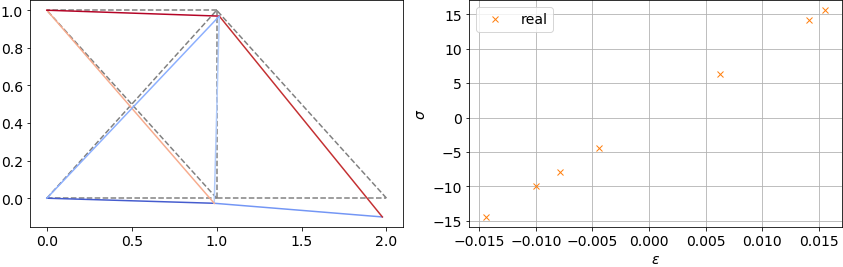

In [27]:
points = np.array([
    [0, 0],
    [1, 0],
    [2, 0],
    [1, 1],
    [0, 1],
])
lines = np.array([
    [0, 1],
    [1, 2],
    [2, 3],
    [1, 3],
    [1, 4],
    [3, 4],
    [0, 3],
], dtype=int)

truss = Truss(points, lines)

E = 1e3
U_dict = {0: 0, 4: 0}
F_dict = {2: [0, -10]}

u, eps_ref, sig_ref = truss.solve(E=E, U_dict=U_dict, F_dict=F_dict, refactor_K=True)
plot_eps_sig_data(eps_ref, sig_ref)

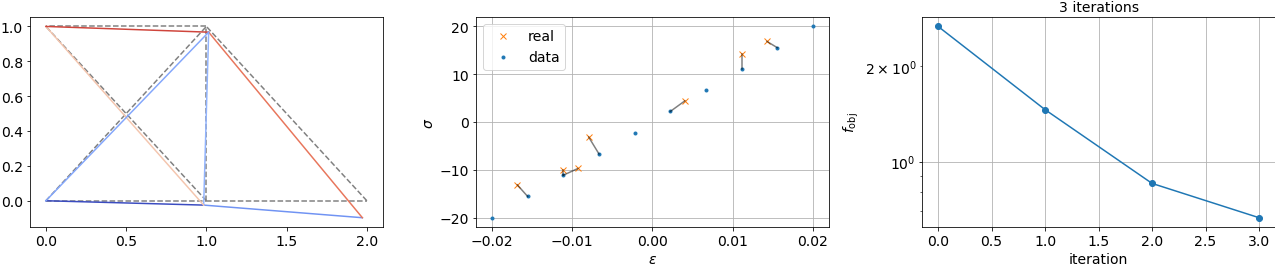

In [28]:
ddsolver = DataDrivenSolver(truss)

eps_data = np.linspace(-0.02, 0.02, 10)
sig_data = E * eps_data
material_data = np.hstack([eps_data.reshape((-1, 1)), sig_data.reshape((-1, 1))])
ddsolver.load_material_data(material_data)

u, eps, sig, f_obj_iter = ddsolver.solve(U_dict=U_dict, F_dict=F_dict)
plot_eps_sig_data(eps, sig, ddsolver, f_obj_iter)

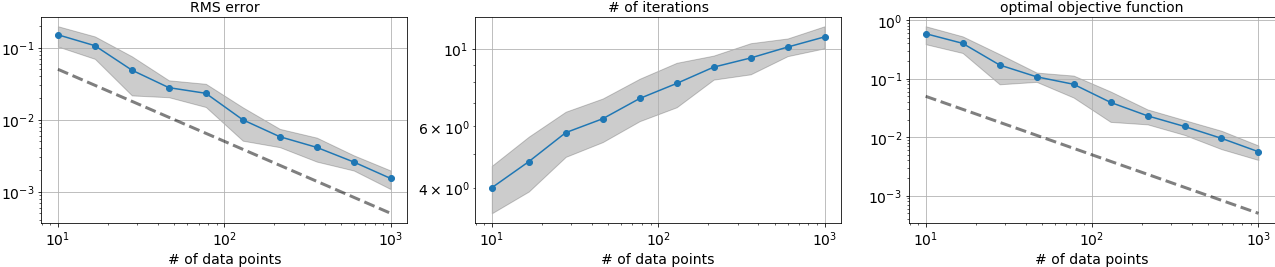

In [6]:
n_runs = 20
n_data = np.logspace(1, 3, 10)
error_eps = np.zeros((n_runs, len(n_data)))
n_iterations = np.zeros((n_runs, len(n_data)))
f_obj = np.zeros((n_runs, len(n_data)))

fig, ax = plt.subplots(1, 3, figsize=(18, 4))

for i_run in range(n_runs):
    for i_data in range(len(n_data)):
        eps_data = np.linspace(-0.02, 0.02, n_data[i_data])
        sig_data = E * eps_data
        material_data = np.hstack([eps_data.reshape((-1, 1)), sig_data.reshape((-1, 1))])
        ddsolver.load_material_data(material_data)
        u, eps, sig, f_obj_iter = ddsolver.solve(U_dict=U_dict, F_dict=F_dict)
        error_eps[i_run, i_data] = rms_error(eps_ref, eps)
        n_iterations[i_run, i_data] = len(f_obj_iter)
        f_obj[i_run, i_data] = f_obj_iter[-1]

def subplot(ax, data, title):
    mean = data.mean(axis=0)
    ax.loglog(n_data, mean, "-o")
    std = data.std(axis=0)
    ax.fill_between(n_data, mean - 1.96 * std, mean + 1.96 * std, color="k", alpha=0.2)
    ax.set_xlabel("# of data points")
    ax.set_title(title)
    ax.grid()

subplot(ax[0], error_eps, "RMS error")
ax[0].loglog(n_data, 0.5 / n_data, "k--", linewidth=3, alpha=0.5)

subplot(ax[1], n_iterations, "# of iterations")
subplot(ax[2], f_obj, "optimal objective function")
ax[2].loglog(n_data, 0.5 / n_data, "k--", linewidth=3, alpha=0.5)

fig.tight_layout()

# Noisy data

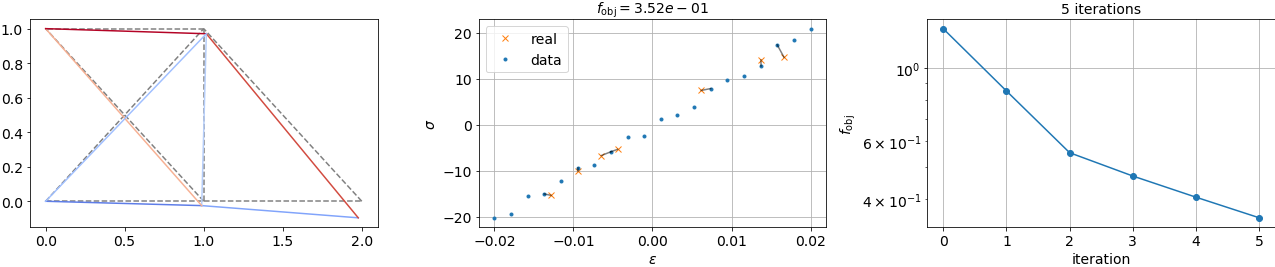

In [7]:
n_data = 20
eps_data = np.linspace(-0.02, 0.02, n_data)
sig_data = E * (eps_data + 0.05 * eps_data.max() * np.random.randn(n_data))
material_data = np.hstack([eps_data.reshape((-1, 1)), sig_data.reshape((-1, 1))])
ddsolver.load_material_data(material_data)

u, eps, sig, f_obj_iter = ddsolver.solve(U_dict=U_dict, F_dict=F_dict)
plot_eps_sig_data(eps, sig, ddsolver, f_obj_iter)

# Nonlinear behavior

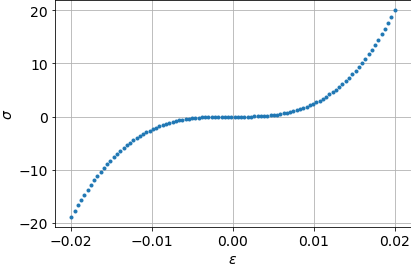

In [35]:
n_data = 100
eps_data = np.linspace(-0.02, 0.02, n_data)
A = 20 / (np.exp(0.02) - 1)**3
sig_data = A * (np.exp(eps_data) - 1)**3
plt.plot(eps_data, sig_data, ".")
plt.grid()
plt.xlabel(r"$\varepsilon$")
plt.ylabel(r"$\sigma$")
plt.tight_layout()

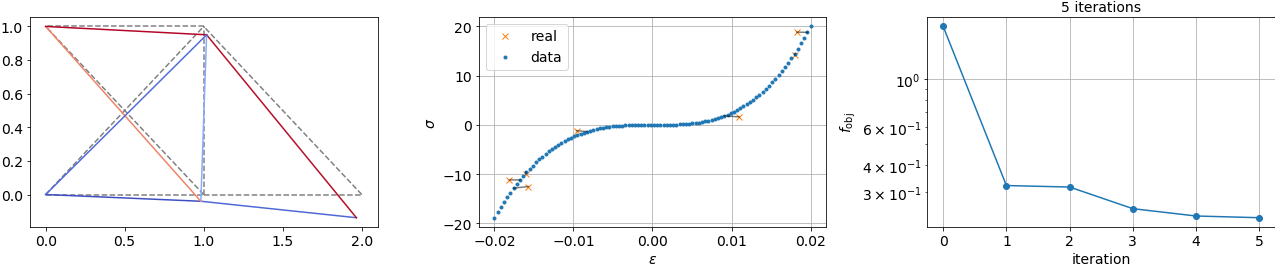

In [44]:
material_data = np.hstack([eps_data.reshape((-1, 1)), sig_data.reshape((-1, 1))])
ddsolver.load_material_data(material_data)

u, eps, sig, f_obj_iter = ddsolver.solve(U_dict=U_dict, F_dict=F_dict)
plot_eps_sig_data(eps, sig, ddsolver, f_obj_iter)